In [1]:
import tensorflow as tf

from src.models.MobilNet2 import create_mobilNet

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [2]:
# Registrar el modelo 
# https://www.mlflow.org/docs/latest/python_api/mlflow.tensorflow.html
# import mlflow.tensorflow
#
# mlflow.tensorflow.autolog()

In [3]:
import os

path_to_clasification = "BinaryBM"
print("Maligno: ", len(os.listdir("data/dataset_raw/MINI-DDSM/" + path_to_clasification + "/maligno")))
print("Benigno: ", len(os.listdir("data/dataset_raw/MINI-DDSM/" + path_to_clasification + "/benigno")))

Maligno:  2716
Benigno:  2684


Found 3781 images belonging to 2 classes.
Found 1619 images belonging to 2 classes.


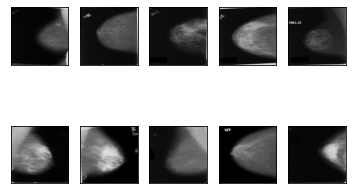

In [4]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=3,
    #     https://stackoverflow.com/questions/62484597/understanding-width-shift-range-and-height-shift-range-arguments-in-kerass
    #     width_shift_range = 0.05,
    #     height_shift_range = 0.05,
    # horizontal_flip=True,
    # https://stackoverflow.com/questions/57301330/what-exactly-the-shear-do-in-imagedatagenerator-of-keras
    # shear_range=2,
    #     preprocessing_function=gray_to_rgb,
    # zoom_range=[0.3, 0.5],
    validation_split=0.3  #20% para pruebas
)
# data/dataset_raw/MINI-DDSM/binary_classification/
#Generadores para sets de entrenamiento y pruebas

data_gen_train = datagen.flow_from_directory('data/dataset_raw/MINI-DDSM/' + path_to_clasification + '/',
                                             batch_size=24, shuffle=True, target_size=(224, 224),
                                             class_mode='binary',
                                             subset='training')
# color_mode='grayscale'
data_gen_test = datagen.flow_from_directory('data/dataset_raw/MINI-DDSM/' + path_to_clasification + '/',
                                            batch_size=24, target_size=(224, 224), shuffle=True,
                                            class_mode='binary',
                                            subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_train:
    for i in range(10):
        # print(imagen[i].shape)
        # print(etiqueta[i])
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imagen[i], cmap='gray')

    break
plt.show()


In [5]:
from src.models.CNN import create_basic_cnn_model
from src.models.MobilNet2 import create_mobilNet

model = create_mobilNet()


Si nueva configuración
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 62720)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               32113152  
_________________________________________________________________
Dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 34,387,585
Trainable params: 34,353,473
Non-trainable params: 34,112
________________

In [6]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy

learning_rate = 1e-6
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Ejecución de entrenamiento solo en jupyer
EPOCAS = 15
batch_size = 24
history = model.fit(
    data_gen_train, epochs=EPOCAS, batch_size=batch_size,
    validation_data=data_gen_test
)
tf.keras.models.save_model(model, ".models/mobilnet1")

Epoch 1/15
158/158 [==============================] - 91s 518ms/step - loss: 0.8177 - accuracy: 0.5327 - val_loss: 0.8051 - val_accuracy: 0.4836

INFO:tensorflow:Assets written to: .models/mobilnet1\assets


INFO:tensorflow:Assets written to: .models/mobilnet1\assets
E:\anaconda3\envs\env_breast_cancer\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [8]:
import mlflow
from mlflow.entities import Metric
from mlflow.tracking import MlflowClient

with mlflow.start_run() as active_run:
    mlflow_client = MlflowClient()
    # experiment_id = "0"
    # run = mlflow_client.create_run(experiment_id)
    all_metrics = []
    for metric_name in history.history:
        for i in history.epoch:
            metric = Metric(
                key=metric_name,
                value=history.history[metric_name][i],
                timestamp=0,
                step=i,
            )
            all_metrics.append(metric)

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="batch_size", value=batch_size)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="learning_rate", value=learning_rate)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="epochs", value=EPOCAS)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="optimizer", value=optimizer.__class__.__name__)
    mlflow_client.log_artifacts(run_id=active_run.info.run_id, local_dir =".models/mobilnet1")

In [9]:
# Correr mlFlow guardadno solamnete la inicial epoca
# mlflow.set_tracking_uri('http://127.0.0.1:5000')
# tracking_uri = mlflow.get_tracking_uri()
# i = 0
# with mlflow.start_run(run_name='PARENT_RUN') as parent_run:
#     mlflow.log_param("batch_size", batch_size)


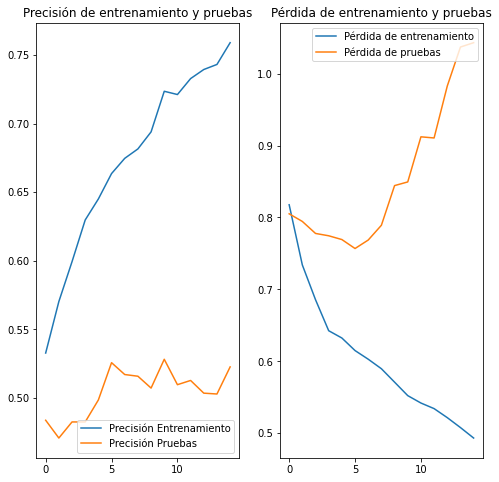

In [10]:
# for v_accuracy in history.history['val_accuracy']:
#     mlflow.log_metric(key="accuracy",
#                       value=v_accuracy,
#                       step=EPOCAS)

#Graficas de precisión
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

rango_epocas = range(EPOCAS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1, 2, 2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [11]:
import pandas as pd

column_values = ['precision de train',
                 'precision de pruebas',
                 'perdida de train',
                 'perdida de pruebas']
array = list(zip(acc, val_acc, loss, val_loss))
df = pd.DataFrame(data=array, columns=column_values)
df


,precision de train,precision de pruebas,perdida de train,perdida de pruebas
0,0.532663,0.483632,0.817708,0.805124
1,0.570220,0.470661,0.733950,0.794488
2,0.599312,0.482397,0.685629,0.777800
3,0.629728,0.482397,0.642498,0.774551
4,0.645067,0.498456,0.632358,0.769303
5,0.663581,0.525633,0.614879,0.756838
6,0.674689,0.516986,0.602859,0.768626
7,0.681566,0.515750,0.589614,0.789189
8,0.693996,0.507103,0.570949,0.844355
9,0.723618,0.528104,0.552202,0.849451


In [12]:
df.describe()

,precision de train,precision de pruebas,perdida de train,perdida de pruebas
count,15.000000,15.000000,15.000000,15.000000
mean,0.674019,0.504138,0.602752,0.854371
std,0.067696,0.017541,0.089700,0.099548
min,0.532663,0.470661,0.493220,0.756838
25%,0.637398,0.491044,0.538025,0.776175
50%,0.681566,0.507103,0.589614,0.805124
75%,0.728247,0.516368,0.637428,0.911401
max,0.759058,0.528104,0.817708,1.043132


In [13]:
mlflow.end_run()
print("Se detuvo MLFlow")

Se detuvo MLFlow
